# KNN 
Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN para classificação
- 2) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

Conclusão: 

- $k=1$ temos alta variância (overfitting - pense nos outliers!).

- $k=N$ temos alto viés (underfittinf - não aprendemos nada, só predizemos diretamente a classe majoritária na base de treino).

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

KNN é um método LAZY LEARNER -- Ou seja, **não há uma etapa explícita de treinamento**, conforme vimos antes.

Cada observação de teste é classificada por vez, segundo o passo a passo acima.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [2]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [3]:
df = pd.read_csv("datasets/breast_cancer.csv")

In [7]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


[[71  1]
 [ 4 38]]


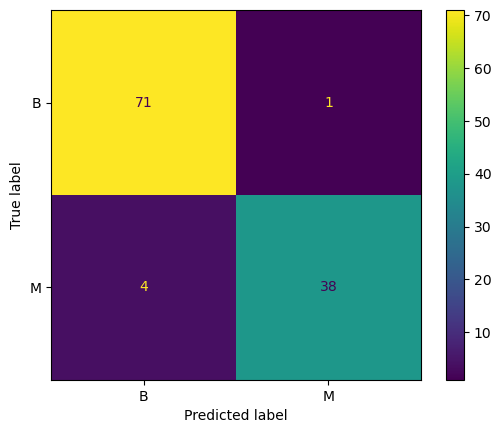

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [  9 161]]


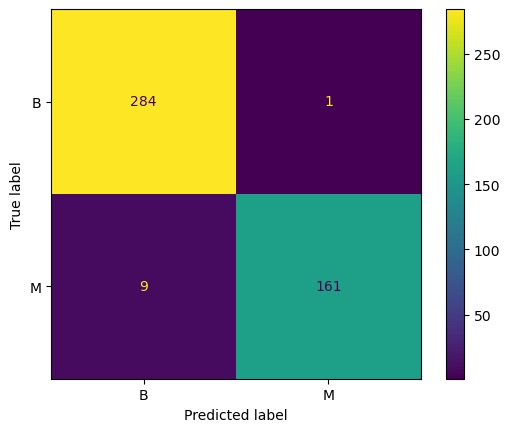

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ====================

df = pd.read_csv("datasets/breast_cancer.csv") # CARREGANDO OS DADOS

# SEPARANDO EM FEATURES E TARGET: APRENDIZADO SUPERVISIONADO
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# PARTICIONANDO OS DADOS
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

# PADRONIZANDO A ESCALA DOS DADOS
ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train) # TREINANDO MEU MODELO

# ====================

y_pred_test = knn.predict(X_test_ss) # FAZENDO A PREDIÇÃO

# AVALIANDO O MODELO
print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = knn.predict(X_train_ss)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))


Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!


Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

Começaremos com o  [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - **média 0 e std 1**

In [22]:
from sklearn.preprocessing import StandardScaler



Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **deixa o espaço amostral entre 0 e 1**

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

In [28]:
from sklearn.preprocessing import MinMaxScaler


Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

Classe: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Entendendo a classificação

**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!

____
____
____

## 3) KNN para regressão

O KNN é nosso primeiro exemplo de algoritmo que pode ser utilizado para ambos os problemas de classificação e regressão!

A ideia é bem simples: o target atribuído a uma nova observação é igual à **média do target das $k$ observações mais próximas**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

Naturalmente, também para regressão o parâmetro $k$ e a métrica de distância são hiperparâmetros importantes:

<img src="https://i.stack.imgur.com/gAILq.png" width=500>

A classe no sklearn é a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Dê uma olhada no User Guide e também no [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [5]:
from sklearn.neighbors import KNeighborsRegressor